## Importa√ß√£o das bibliotecas

In [ ]:
# Instalar a biblioteca wordcloud, se necess√°rio
%pip install wordcloud

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive
import seaborn as sns
import pandas as pd
import numpy as np
import kagglehub
import itertools
import duckdb
import nltk
import os

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

pd.set_option('display.max_colwidth', None)

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Coleta dos dados

### Leitura de Dados do Kaggle

In [ ]:
# Download latest version
path = kagglehub.dataset_download("zynicide/wine-reviews")
file_path = os.path.join(path, "winemag-data-130k-v2.csv")

df_wine = pd.read_csv(file_path, index_col=0)

print(f'''
-> Path para o DataSet: {path}
-> Arquivos: {os.listdir(path)}
=> Arquivo Selecionado: {file_path}''')

Using Colab cache for faster access to the 'wine-reviews' dataset.

-> Path para o DataSet: /kaggle/input/wine-reviews
-> Arquivos: ['winemag-data_first150k.csv', 'winemag-data-130k-v2.json', 'winemag-data-130k-v2.csv']
=> Arquivo Selecionado: /kaggle/input/wine-reviews/winemag-data-130k-v2.csv


### Leitura pr√©-treinada

In [ ]:
## Removido por enquanto pois CSV n√£o salva os Embeddings corretamente.

# drive.mount('/content/drive')

# df_wine = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/models/wine_embedded.csv')

# df_wine["embedding"] = df_wine["embedding"].apply(lambda row: np.vstack(row))
# display(df_wine.columns)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name', 'title',
       'variety', 'winery', 'log_preco', 'faixa_preco', 'faixa_pontos',
       'sentiment', 'tokens', 'embedding'],
      dtype='object')

In [ ]:
# Remove coluna inutil
if 'taster_twitter_handle' in df_wine:
  df_wine.drop("taster_twitter_handle", axis=1, inplace=True)

False

In [ ]:
# Lista quantidade de linhas e colunas
def query(qry):
  return duckdb.query(qry).df()

print(f'''
Linhas: {len(df_wine)}
Colunas: {len(df_wine.columns)} - {df_wine.columns.values}
''')


Linhas: 129971
Colunas: 12 - ['country' 'description' 'designation' 'points' 'price' 'province'
 'region_1' 'region_2' 'taster_name' 'title' 'variety' 'winery']



# 1¬™ An√°lise de Dados

## Cabe√ßalho

In [ ]:
#Imprime as primeiras linhas
df_wine.head()

country  \
0     Italy   
1  Portugal   
2        US   
3        US   
4        US   

                                                                                                                                                                                                                                                 description  \
0                                                                               Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.   
1                        This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.   
2                                                                 Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.   
3                                                    Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.   
4  Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.   

                          designation  points  price           province  \
0                        Vulk√† Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0                 Etna                NaN       Kerin O‚ÄôKeefe   
1                  NaN                NaN          Roger Voss   
2    Willamette Valley  Willamette Valley        Paul Gregutt   
3  Lake Michigan Shore                NaN  Alexander Peartree   
4    Willamette Valley  Willamette Valley        Paul Gregutt   

                                                                                 title  \
0                                                    Nicosia 2013 Vulk√† Bianco  (Etna)   
1                                        Quinta dos Avidagos 2011 Avidagos Red (Douro)   
2                                        Rainstorm 2013 Pinot Gris (Willamette Valley)   
3                  St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore)   
4  Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley)   

          variety               winery  
0     White Blend              Nicosia  
1  Portuguese Red  Quinta dos Avidagos  
2      Pinot Gris            Rainstorm  
3        Riesling           St. Julian  
4      Pinot Noir         Sweet Cheeks

## Rodap√©

In [ ]:
df_wine.tail()

country  \
129966  Germany   
129967       US   
129968   France   
129969   France   
129970   France   

                                                                                                                                                                                                                                      description  \
129966        Notes of honeysuckle and cantaloupe sweeten this deliciously feather-light sp√§tlese. It's intensely juicy, quenching the palate with streams of tart tangerine and grapefruit acidity, yet wraps up with a kiss of honey and peach.   
129967  Citation is given as much as a decade of bottle age prior to release, which means it is pre-cellared and drinking at its peak. Baked cherry, cocoa and coconut flavors combine gracefully, with soft, secondary fruit compote highlights.   
129968          Well-drained gravel soil gives this wine its crisp and dry character. It is ripe and fruity, although the spice is subdued in favor of a more serious structure. This is a wine to age for a couple of years, so drink from 2017.   
129969                   A dry style of Pinot Gris, this is crisp with some acidity. It also has weight and a solid, powerful core of spice and baked apple flavors. With its structure still developing, the wine needs to age. Drink from 2015.   
129970                                                                  Big, rich and off-dry, this is powered by intense spiciness and rounded texture. Lychees dominate the fruit profile, giving an opulent feel to the aftertaste. Drink now.   

                                   designation  points  price province  \
129966  Brauneberger Juffer-Sonnenuhr Sp√§tlese      90   28.0    Mosel   
129967                                     NaN      90   75.0   Oregon   
129968                                   Kritt      90   30.0   Alsace   
129969                                     NaN      90   32.0   Alsace   
129970           Lieu-dit Harth Cuv√©e Caroline      90   21.0   Alsace   

       region_1      region_2         taster_name  \
129966      NaN           NaN  Anna Lee C. Iijima   
129967   Oregon  Oregon Other        Paul Gregutt   
129968   Alsace           NaN          Roger Voss   
129969   Alsace           NaN          Roger Voss   
129970   Alsace           NaN          Roger Voss   

                                                                                                        title  \
129966  Dr. H. Thanisch (Erben M√ºller-Burggraef) 2013 Brauneberger Juffer-Sonnenuhr Sp√§tlese Riesling (Mosel)   
129967                                                                      Citation 2004 Pinot Noir (Oregon)   
129968                                                     Domaine Gresser 2013 Kritt Gewurztraminer (Alsace)   
129969                                                          Domaine Marcel Deiss 2012 Pinot Gris (Alsace)   
129970                            Domaine Schoffit 2012 Lieu-dit Harth Cuv√©e Caroline Gewurztraminer (Alsace)   

               variety                                    winery  
129966        Riesling  Dr. H. Thanisch (Erben M√ºller-Burggraef)  
129967      Pinot Noir                                  Citation  
129968  Gew√ºrztraminer                           Domaine Gresser  
129969      Pinot Gris                      Domaine Marcel Deiss  
129970  Gew√ºrztraminer                          Domaine Schoffit

## Informa√ß√µes tabela

In [ ]:
# Informa√ß√µes da tabela
infos = pd.DataFrame({
    'Quantidade': df_wine.count(),
    'Nulos': df_wine.isnull().sum(),
    'Type': df_wine.dtypes,
    'Percentual nulos': (df_wine.isnull().sum() / len(df_wine) * 100).map("{:.2f}%".format)
})

infos.head(100)

Quantidade  Nulos     Type Percentual nulos
country          129908     63   object            0.05%
description      129971      0   object            0.00%
designation       92506  37465   object           28.83%
points           129971      0    int64            0.00%
price            120975   8996  float64            6.92%
province         129908     63   object            0.05%
region_1         108724  21247   object           16.35%
region_2          50511  79460   object           61.14%
taster_name      103727  26244   object           20.19%
title            129971      0   object            0.00%
variety          129970      1   object            0.00%
winery           129971      0   object            0.00%

In [ ]:
# Descobrir os valores √∫nicos contidos nas colunas
# Isso ajuda a entender melhor a estrutura dos dados e identificar colunas categ√≥ricas, num√©ricas, e at√© erros (valores inesperados).

for col in df_wine.columns:
    print(f"\nColuna: {col}")
    print("Valores √∫nicos:", df_wine[col].unique())

unique_counts = pd.DataFrame({
    'Coluna': df_wine.columns,
    'Valores √önicos': df_wine.nunique().values
})

print("\n" * 2)

unique_counts.head(100)


Coluna: country
Valores √∫nicos: ['Italy' 'Portugal' 'US' 'Spain' 'France' 'Germany' 'Argentina' 'Chile'
 'Australia' 'Austria' 'South Africa' 'New Zealand' 'Israel' 'Hungary'
 'Greece' 'Romania' 'Mexico' 'Canada' nan 'Turkey' 'Czech Republic'
 'Slovenia' 'Luxembourg' 'Croatia' 'Georgia' 'Uruguay' 'England' 'Lebanon'
 'Serbia' 'Brazil' 'Moldova' 'Morocco' 'Peru' 'India' 'Bulgaria' 'Cyprus'
 'Armenia' 'Switzerland' 'Bosnia and Herzegovina' 'Ukraine' 'Slovakia'
 'Macedonia' 'China' 'Egypt']

Coluna: description
Valores √∫nicos: ["Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity."
 "This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016."
 'Tart and snappy, the flavors of lime flesh and rind domina

Coluna  Valores √önicos
0       country              43
1   description          119955
2   designation           37979
3        points              21
4         price             390
5      province             425
6      region_1            1229
7      region_2              17
8   taster_name              19
9         title          118840
10      variety             707
11       winery           16757

## Estat√≠stica descritiva

In [ ]:
# Vamos selecionar apenas as colunas "points" e "price" para fazer a estat√≠stica descritiva.
df_dataset_PointsPrice = df_wine[["points", "price"]]
df_dataset_PointsPrice.describe()

points          price
count  129971.000000  120975.000000
mean       88.447138      35.363389
std         3.039730      41.022218
min        80.000000       4.000000
25%        86.000000      17.000000
50%        88.000000      25.000000
75%        91.000000      42.000000
max       100.000000    3300.000000

## Tipos de vinhos por pa√≠s

### Quantidade

In [ ]:
# Contagem de variedades √∫nicas por pa√≠s
variedades_pais = df_wine.groupby('country')['variety'].nunique().reset_index()
variedades_pais.columns = ['Pa√≠s', 'Quantidade de variedades']

# Calcular percentual
total_variedades = variedades_pais['Quantidade de variedades'].sum()
variedades_pais['Percentual'] = (variedades_pais['Quantidade de variedades'] / total_variedades * 100).map("{:.2f}%".format)

# Ordenar do maior para o menor
variedades_pais = variedades_pais.sort_values(by='Quantidade de variedades', ascending=False)

# Mostrar as 10 primeiras linhas como tabela
variedades_pais.head(100).style.set_caption("Quantidade de variedades de vinho por pa√≠s")


### Gr√°fico



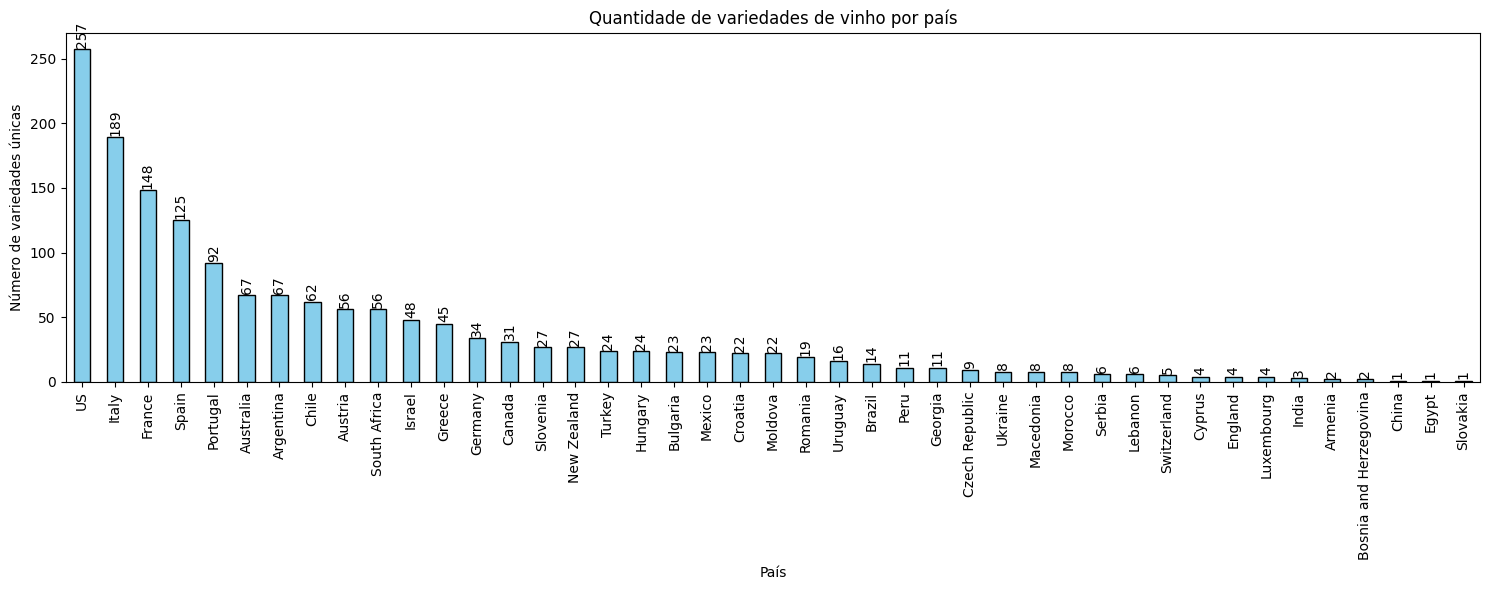

In [ ]:
# Quantidade de variedades √∫nicas por pa√≠s
variedades_por_pais = df_wine.groupby('country')['variety'].nunique().sort_values(ascending=False)

# Gr√°fico de barras
plt.figure(figsize=(15,6))
ax = variedades_por_pais.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Quantidade de variedades de vinho por pa√≠s')
plt.xlabel('Pa√≠s')
plt.ylabel('N√∫mero de variedades √∫nicas')
plt.xticks(rotation=90)

# Mostrar valores em cima das barras
for i, v in enumerate(variedades_por_pais):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', rotation=90)

plt.tight_layout()
plt.show()


### *An√°lise*

> Os dados mostram que o dataset √© fortemente desbalanceado em rela√ß√£o √† quantidade de variedades de vinhos por pa√≠s. Observa-se que poucos pa√≠ses, como Estados Unidos, Fran√ßa e It√°lia, concentram a maior parte das variedades registradas, enquanto a maioria dos outros pa√≠ses aparece com pouqu√≠ssimas variedades. Esse desbalanceamento pode afetar diretamente a qualidade de um modelo de IA que tente aprender padr√µes de vinhos globais, pois o conhecimento estar√° enviesado para os pa√≠ses com maior representatividade.

#### *Problemas de usar um dataset desbalanceado em IA*

* **Vi√©s do modelo**: o algoritmo tender√° a aprender mais sobre as caracter√≠sticas dos vinhos dos pa√≠ses majorit√°rios (EUA, Fran√ßa, It√°lia), ignorando ou representando mal pa√≠ses com menos exemplos;

* **Generaliza√ß√£o limitada**: o modelo ter√° dificuldade em prever ou recomendar vinhos de pa√≠ses com baixa quantidade de dados, comprometendo sua utilidade pr√°tica em contextos internacionais;

* **M√©tricas enganosas**: uma m√©trica simples como acur√°cia pode parecer boa, mas isso se deve ao grande n√∫mero de registros de poucos pa√≠ses, mascarando o baixo desempenho nos pa√≠ses minorit√°rios.

#### *O que deve ser feito*

> Existem algumas abordagens para mitigar esse problema:

> a. **Rebalanceamento**
>
> * **Oversampling**: aumentar artificialmente as variedades de pa√≠ses pouco representados (com t√©cnicas como SMOTE), gerando dados sint√©ticos;
> * **Undersampling**: reduzir o n√∫mero de exemplos dos pa√≠ses dominantes para equilibrar o dataset;
> * **Combina√ß√£o**: usar oversampling para pa√≠ses minorit√°rios e undersampling para os majorit√°rios.

> b. **M√©tricas de avalia√ß√£o**
>
> * Utilizar m√©tricas como *precision*, *recall*, *F1-score*, matriz de confus√£o e ROC-AUC, que avaliam melhor o desempenho em contextos desbalanceados.

> c. **Algoritmos e t√©cnicas espec√≠ficas**
>
> * Modelos como *RandomForest* ou *XGBoost* com pesos ajustados para dar mais relev√¢ncia a pa√≠ses minorit√°rios;
> * Uso de **class weights** para aumentar a import√¢ncia dos pa√≠ses menos representados.

> d. **Estrat√©gia**
>
> * Avaliar se todos os pa√≠ses precisam ser tratados igualmente no modelo.
> * Pa√≠ses com quantidades extremamente pequenas podem ser tratados como **anomalias/outliers** em vez de classes principais.

#### *Resumindo*

> O principal risco √© o modelo aprender apenas os padr√µes de pa√≠ses dominantes e n√£o conseguir identificar corretamente vinhos de pa√≠ses minorit√°rios. Para evitar isso, √© fundamental: **balancear o dataset**, **ajustar m√©tricas de avalia√ß√£o** e/ou **usar t√©cnicas e algoritmos adequados para lidar com desbalanceamento**.



## Pontua√ß√£o de vinhos por pa√≠s

### Quantidade M√©dia

In [ ]:
pontuacao_pais = df_wine.groupby('country')['points'].mean().reset_index()
pontuacao_pais.columns = ['Pa√≠s', 'Pontua√ß√£o']

pontuacao_pais = pontuacao_pais.sort_values(by='Pontua√ß√£o', ascending=False)

pontuacao_pais.head(100).style.set_caption("Quantidade de variedades de vinho por pa√≠s")

### Grafico Quantidade


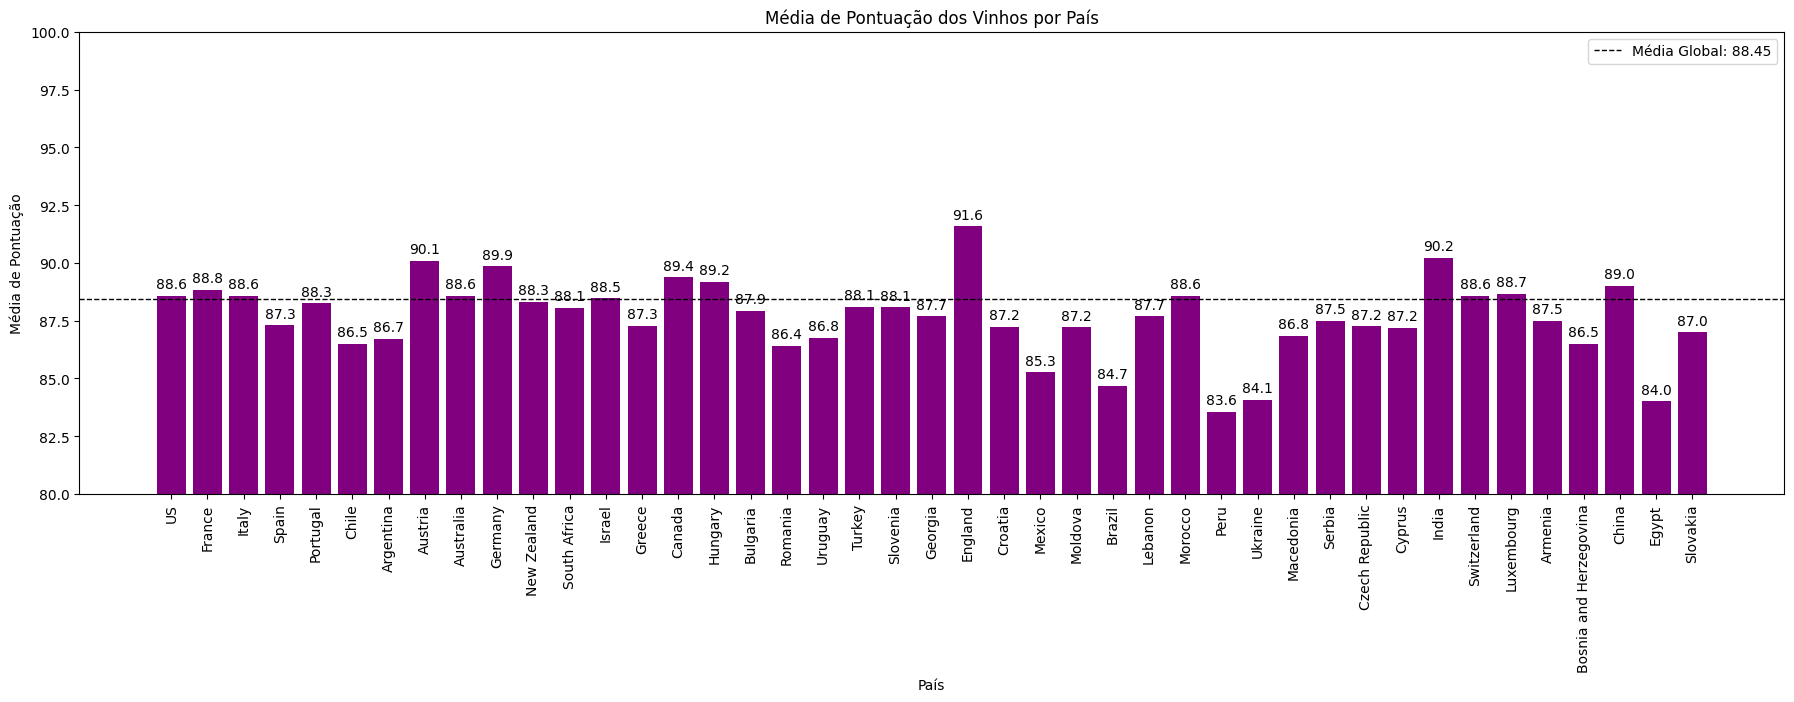

In [ ]:
# Top 10 pa√≠ses com mais vinhos avaliados
# Estat√≠sticas por pa√≠s
stats_por_pais = df_wine.groupby('country')['points'].agg(['count','mean']).reset_index()
stats_por_pais.columns = ['Pa√≠s', 'Quantidade de Vinhos', 'M√©dia']

# Top 10 pa√≠ses com mais vinhos avaliados
top_paises = stats_por_pais.sort_values(by='Quantidade de Vinhos', ascending=False).head(100)

# Criar gr√°fico
fig, ax = plt.subplots(figsize=(22,6))
bars = ax.bar(top_paises['Pa√≠s'], top_paises['M√©dia'], color='purple')

# Calculate the overall average points
overall_mean_points = df_wine['points'].mean()

# Add a horizontal line for the overall average
ax.axhline(overall_mean_points, color='black', linestyle='dashed', linewidth=1, label=f'M√©dia Global: {overall_mean_points:.2f}')
ax.legend()

# T√≠tulo e r√≥tulos
ax.set_title('M√©dia de Pontua√ß√£o dos Vinhos por Pa√≠s')
ax.set_xlabel('Pa√≠s')
ax.set_ylabel('M√©dia de Pontua√ß√£o')
plt.xticks(rotation=90)

# Limit the y-axis
ax.set_ylim(80, 100)

# Adicionar os valores em cima das barras
for bar, media in zip(bars, top_paises['M√©dia']):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.2,
        f"{media:.1f}",
        ha='center', va='bottom', rotation=0, fontsize=10, color='black'
    )

plt.show()

### An√°lise da M√©dia de Pontua√ß√£o dos Vinhos por Pa√≠s

O gr√°fico mostra a m√©dia de pontua√ß√£o atribu√≠da aos vinhos de diferentes pa√≠ses, considerando os 100 pa√≠ses com mais registros no dataset.

Alguns pontos importantes:

1. **N√≠veis pr√≥ximos entre pa√≠ses**

   * A m√©dia das pontua√ß√µes se concentra em uma faixa relativamente estreita (normalmente entre 84 e 90 pontos).
   * Isso indica que, apesar das diferen√ßas regionais, a avalia√ß√£o dos vinhos segue um padr√£o consistente entre os avaliadores, sugerindo uma escala padronizada e crit√©rios homog√™neos.

2. **Diferen√ßa entre quantidade e qualidade**

   * Pa√≠ses com grande quantidade de vinhos avaliados (como Estados Unidos, Fran√ßa e It√°lia) apresentam m√©dias pr√≥ximas da m√©dia global.
   * J√° pa√≠ses com poucas amostras podem aparecer com m√©dias muito altas ou muito baixas, mas isso pode ser efeito do baixo n√∫mero de observa√ß√µes (vi√©s amostral).

3. **Interpreta√ß√£o pr√°tica**

   * O fato de a m√©dia variar pouco entre os pa√≠ses sugere que **a quantidade de registros √© mais relevante que a m√©dia isolada**.
   * Isso √© um alerta para o uso de IA: pa√≠ses com muitos vinhos avaliados dar√£o mais robustez ao modelo, enquanto pa√≠ses pouco representados podem distorcer a an√°lise se tratados da mesma forma.

4. **Pr√≥ximos passos na an√°lise**

   * Verificar a **distribui√ß√£o das notas** (ex.: histogramas por pa√≠s) para ver se existem pa√≠ses com notas mais concentradas ou mais dispersas.
   * Cruzar pontua√ß√£o com outras vari√°veis (como variedade, pre√ßo ou regi√£o) para entender melhor o que influencia a avalia√ß√£o.
   * Considerar t√©cnicas de **normaliza√ß√£o ou balanceamento**, principalmente para pa√≠ses com poucas amostras, a fim de evitar vi√©s no modelo de IA.

Conclus√£o

Apesar de algumas diferen√ßas pontuais, a m√©dia de pontua√ß√£o por pa√≠s sugere que a escala de avalia√ß√£o √© consistente e padronizada, mas o desbalanceamento no n√∫mero de registros entre pa√≠ses √© um fator cr√≠tico que deve ser tratado para que o modelo de IA seja realmente representativo.


### Grafico de disper√ß√£o

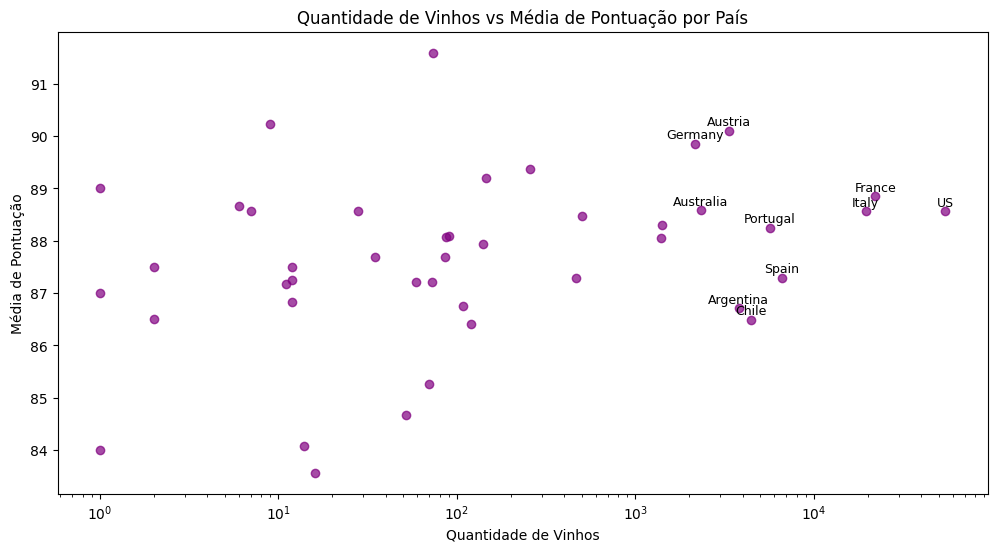

In [ ]:
# Estat√≠sticas por pa√≠s
stats_por_pais = df_wine.groupby('country')['points'].agg(['count','mean']).reset_index()
stats_por_pais.columns = ['Pa√≠s', 'Quantidade de Vinhos', 'M√©dia']

# Criar gr√°fico de dispers√£o
plt.figure(figsize=(12,6))
plt.scatter(stats_por_pais['Quantidade de Vinhos'], stats_por_pais['M√©dia'], alpha=0.7, color='purple')

# T√≠tulo e r√≥tulos
plt.title('Quantidade de Vinhos vs M√©dia de Pontua√ß√£o por Pa√≠s')
plt.xlabel('Quantidade de Vinhos')
plt.ylabel('M√©dia de Pontua√ß√£o')

# Escala logar√≠tmica no eixo X
plt.xscale('log')

# Adicionar alguns r√≥tulos dos pa√≠ses com mais vinhos
for i, row in stats_por_pais.sort_values(by='Quantidade de Vinhos', ascending=False).head(10).iterrows():
    plt.text(row['Quantidade de Vinhos'], row['M√©dia']+0.1, row['Pa√≠s'], fontsize=9, ha='center')

plt.show()

### *An√°lise do Gr√°fico de Dispers√£o (Quantidade de Vinhos vs M√©dia de Pontua√ß√£o por Pa√≠s)*

1) Padr√£o geral  
- A m√©dia de pontua√ß√£o por pa√≠s varia pouco (aprox. 84‚Äì90), independentemente da quantidade de vinhos avaliados.  
- A escala log no eixo X evidencia a assimetria: poucos pa√≠ses concentram muitas avalia√ß√µes; a maioria tem poucas.

2) Efeito do tamanho da amostra  
- Pa√≠ses com muitas avalia√ß√µes (√† direita) apresentam m√©dias mais est√°veis e pr√≥ximas da m√©dia global.  
- Pa√≠ses com poucas avalia√ß√µes (√† esquerda) exibem maior variabilidade aparente; extremos podem refletir vi√©s amostral (n√£o necessariamente qualidade real).

3) Interpreta√ß√£o pr√°tica  
- A m√©dia isolada pode ser enganosa para pa√≠ses pouco representados. Para compara√ß√µes, atribua maior peso a pa√≠ses com maior N ou considere a incerteza.  
- N√£o h√° correla√ß√£o forte entre ‚Äúquantidade‚Äù e ‚Äúm√©dia‚Äù: mais dados aumentam a estabilidade da estimativa, n√£o a nota m√©dia.

4) Observa√ß√£o dos pa√≠ses com maior N  
- Os pa√≠ses rotulados (top 10 em quantidade) confirmam o padr√£o: m√©dias pr√≥ximas e dispers√£o vertical reduzida, sugerindo consist√™ncia da escala de avalia√ß√£o.

5) Pr√≥ximos passos recomendados  
- Intervalos de confian√ßa: adicionar barras de erro (ex.: 95%) para explicitar a incerteza por pa√≠s.  
- Visual ponderado: dimensionar o tamanho dos pontos proporcional √† contagem (s ~ N) para comunicar representatividade.  
- Robustez: aplicar filtro por N m√≠nimo (ex.: N ‚â• 50) ao comparar m√©dias, reduzindo ru√≠do.  
- Shrinkage/Empirical Bayes: ‚Äúcontrair‚Äù m√©dias de pa√≠ses com poucos dados em dire√ß√£o √† m√©dia global, mitigando vi√©s de amostra pequena.  
- Camadas por pre√ßo/variedade: facetar ou colorir por faixas de pre√ßo para verificar intera√ß√µes entre quantidade, pre√ßo e pontua√ß√£o.

Conclus√£o  
- A m√©dia por pa√≠s √© relativamente est√°vel; o principal cuidado √© o desbalanceamento no n√∫mero de observa√ß√µes. Para compara√ß√µes justas e modelos de IA, √© bom considerar ponderar por N, incluir intervalos de confian√ßa e/ou t√©cnicas bayesianas, al√©m de aplicar um N m√≠nimo por pa√≠s.


## Distribui√ß√£o de pre√ßo e pontos

### Distribui√ß√£o de Pre√ßo e Pontos (Histograma + KDE)


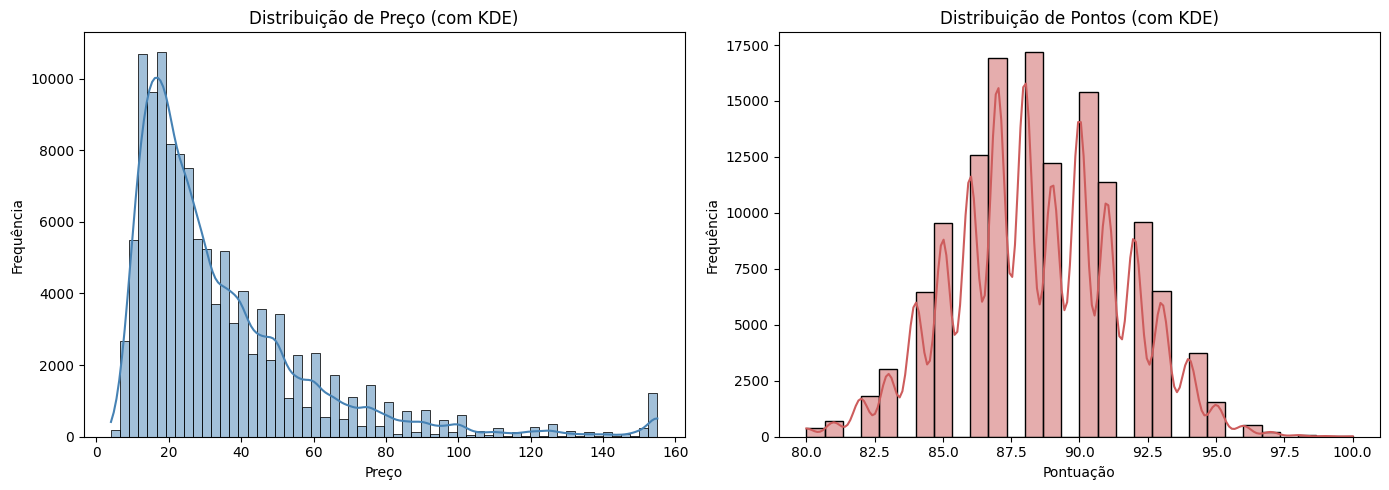

In [ ]:
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Pre√ßo: cauda longa ‚Üí remover nulos e limitar extremos opcionais para visualiza√ß√£o
precos = df_wine['price'].dropna()
precos_clip = precos.clip(upper=precos.quantile(0.99))  # evita distor√ß√£o por outliers extremos

sns.histplot(precos_clip, bins=60, kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Distribui√ß√£o de Pre√ßo (com KDE)')
axes[0].set_xlabel('Pre√ßo')
axes[0].set_ylabel('Frequ√™ncia')

# Pontos
pontos = df_wine['points'].dropna()
sns.histplot(pontos, bins=30, kde=True, ax=axes[1], color='indianred')
axes[1].set_title('Distribui√ß√£o de Pontos (com KDE)')
axes[1].set_xlabel('Pontua√ß√£o')
axes[1].set_ylabel('Frequ√™ncia')

plt.tight_layout()
plt.show()

### *An√°lise do Histograma + KDE (Pre√ßo e Pontos)*

#### Pre√ßo
- Cauda longa √† direita: muitos vinhos em faixas de pre√ßo baixas/m√©dias e poucos muito caros.
- Outliers podem distorcer a m√©dia; prefira mediana e quantis para resumir pre√ßo.
- Poss√≠vel multimodalidade indica segmentos (entrada vs. premium).
- Implica√ß√µes: usar escala log ou winsoriza√ß√£o em visualiza√ß√µes; em modelagem, transformar pre√ßo (log) e tratar outliers.

#### Pontos
- Faixa estreita e pico central: notas concentradas (‚âà84‚Äì90), indicando escala padronizada.
- Assimetria leve sugere evitar extremos; pequenas diferen√ßas (1‚Äì2 pts) j√° s√£o relevantes.
- Implica√ß√µes: m√©tricas sens√≠veis (ex.: MAE); procurar efeitos sutis em rela√ß√£o ao pre√ßo (modelos com n√£o linearidade).

#### Conex√µes Pre√ßo √ó Pontos
- Pre√ßo tem cauda longa, enquanto pontos s√£o concentrados: aumentos grandes de pre√ßo n√£o implicam aumentos proporcionais de nota.
- Recomendado avaliar scatter de pre√ßo (em log) vs. pontos para captar tend√™ncias e heterocedasticidade.

## Correla√ß√£o entre pre√ßo e pontua√ß√£o, e pre√ßo vs pontua√ß√£o por Variedade

### Gr√°fico de correla√ß√£o

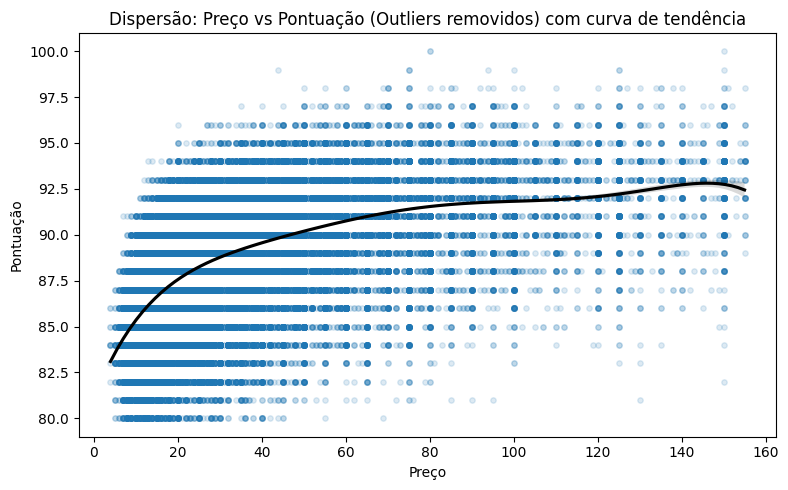

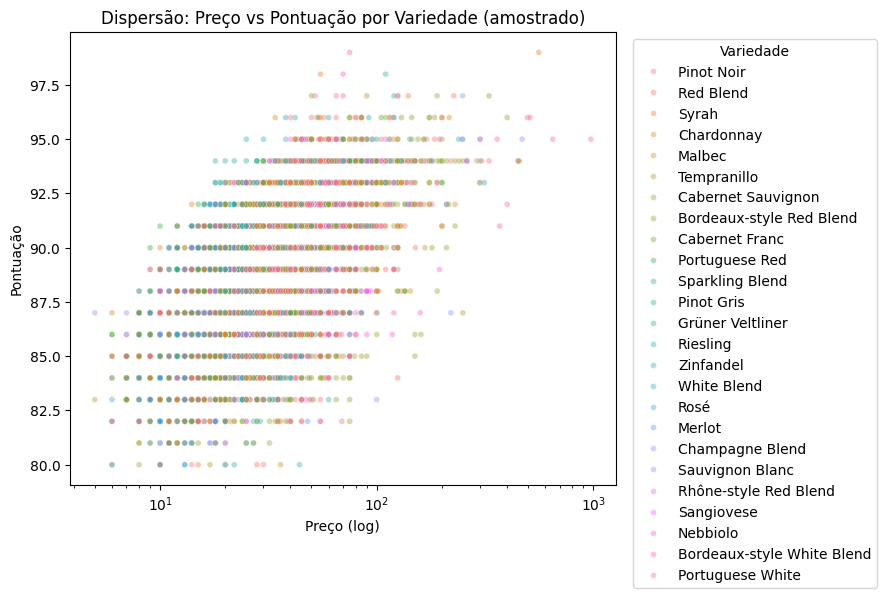

In [ ]:
### Gr√°fico de Dispers√£o: Pre√ßo vs Pontua√ß√£o

# Dispers√£o com tend√™ncia e pre√ßo em escala normal, removendo outliers de pre√ßo
df_scatter = df_wine[['price', 'points']].dropna().copy()
df_scatter = df_scatter[df_scatter['price'] > 0]

# Remove Outliers
price_upper_bound = df_scatter['price'].quantile(0.99)
df_scatter = df_scatter[df_scatter['price'] <= price_upper_bound]

plt.figure(figsize=(8, 5))
sns.regplot(
    data=df_scatter, x='price', y='points',
    scatter_kws={'alpha': 0.15, 's': 15},
    line_kws={'color': 'black'},
    order=6 # Transforma em uma Regress√£o Polinomial
)
plt.title('Dispers√£o: Pre√ßo vs Pontua√ß√£o (Outliers removidos) com curva de tend√™ncia')
plt.xlabel('Pre√ßo')
plt.ylabel('Pontua√ß√£o')
plt.tight_layout()
plt.show()

### Gr√°fico de Dispers√£o por Variedade (amostra)

# Para evitar polui√ß√£o visual, amostra e colore por algumas variedades mais frequentes
top_var = df_wine['variety'].value_counts().head(25).index
sample = df_wine[df_wine['variety'].isin(top_var)][['price', 'points', 'variety']].dropna()
sample = sample[sample['price'] > 0].sample(n=min(8000, len(sample)), random_state=42)

plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=sample, x='price', y='points', hue='variety',
    alpha=0.4, s=18
)
plt.xscale('log')
plt.title('Dispers√£o: Pre√ßo vs Pontua√ß√£o por Variedade (amostrado)')
plt.xlabel('Pre√ßo (log)')
plt.ylabel('Pontua√ß√£o')
plt.legend(title='Variedade', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

### *An√°lise*

#### Dispers√£o: Pre√ßo vs Pontua√ß√£o (x em log)
- Tend√™ncia positiva fraca: a linha de regress√£o indica aumento leve da pontua√ß√£o com o pre√ßo, por√©m o efeito √© modesto.
- Alta variabilidade: para um mesmo n√≠vel de pre√ßo (mesmo em log), h√° ampla faixa de notas; pre√ßo isolado n√£o explica bem a pontua√ß√£o.
- Heterocedasticidade: a dispers√£o vertical varia ao longo do eixo de pre√ßo, sugerindo que um modelo linear simples pode ser insuficiente sem transforma√ß√µes/termos adicionais.
- Implica√ß√µes: usar log(pre√ßo) em modelos, considerar termos n√£o lineares (ex.: splines/√°rvores) e tratar outliers de pre√ßo para reduzir influ√™ncia desproporcional.

#### Dispers√£o: Pre√ßo vs Pontua√ß√£o por Variedade (amostrado)
- Padr√µes por variedade: algumas variedades se concentram em faixas de pre√ßo distintas; diferen√ßas de pontua√ß√£o podem refletir tamb√©m diferen√ßas de pre√ßo (efeito de confus√£o).
- Forte sobreposi√ß√£o: nuvens por variedade se sobrep√µem; n√£o h√° separa√ß√µes claras, mas nuances existem.
- Intera√ß√£o potencial: a rela√ß√£o pre√ßo‚Äìpontua√ß√£o pode variar entre variedades (intera√ß√£o). Modelos com intera√ß√£o variedade √ó log(pre√ßo) podem capturar melhor.
- Implica√ß√µes: ao comparar variedades, controle pre√ßo e pa√≠s/regi√£o (estratifica√ß√£o ou modelos com efeitos fixos/aleat√≥rios). Facetar por faixas de pre√ßo ajuda a evitar vieses.

#### Poss√≠veis pr√≥ximos passos
- Regress√£o com log(pre√ßo) e termos n√£o lineares; testar intera√ß√£o com variedade.
- Quantificar poder explicativo com R¬≤ e erro (MAE/RMSE).
- Facetar por pa√≠s ou subset homog√™neo para reduzir confus√£o.
- Winsorizar/remover outliers extremos de pre√ßo e reavaliar a tend√™ncia.


# Engenharia de dados

### Dropa possiveis colunas completamente nulas

In [ ]:
colunas_nulas = df_wine.columns[df_wine.isnull().all()].tolist()
df_wine = df_wine.drop(columns=colunas_nulas)

print("Colunas totalmente nulas removidas:", len(colunas_nulas))

Colunas totalmente nulas removidas: 0


### Tratamento de Valores Nulos e padroniza√ß√µes
**negrito** Preenche valores Nulos com op√ß√µes validas, e normaliza os campos categoricos
- **price e points**: S√£o preenchido com a mediana, e tipagem √© garantida
- **Resto das colunas categoricas**: S√£o preenchidos com *"Desconhecido"*, e valores s√£o normalizados com `.strip()` e `.lower()`

In [ ]:
# - price e points: S√£o preenchido com a mediana.
df_wine["price"] = df_wine["price"].fillna(df_wine["price"].median()).astype("float64")
df_wine["points"] = df_wine["points"].fillna(df_wine["points"].median()).astype(int)

# - Resto das colunas categoricas: S√£o preenchidos com "Desconhecido", e valores s√£o normalizados com `.strip()` e `.lower()`
categoricos = [
    "country", "province", "region_1", "region_2",
    "taster_name", "designation", "title", "variety", "winery", "description"
]

for col in categoricos:
      df_wine[col] = (
          df_wine[col]
          .fillna("Desconhecido").astype(str)
          .str.strip()
          .str.lower()
      )

### Cria colunas pr√©-processadas
- **log_preco**: transforma√ß√£o logar√≠tmica da coluna `price` usando `log1p` para reduzir a cauda longa e suavizar a distribui√ß√£o de pre√ßos (facilita an√°lises e modelos).  
- **faixa_preco**: categoriza√ß√£o do pre√ßo bruto em faixas (baixo, m√©dio, alto, premium) utilizando quartis, permitindo comparar vinhos em grupos de pre√ßo.  
- **faixa_pontos**: categoriza√ß√£o das notas (`points`) em intervalos de qualidade (regular, bom, muito bom, excelente), facilitando a interpreta√ß√£o e an√°lises comparativas.


In [ ]:
df_wine["log_preco"] = np.log1p(df_wine["price"])

df_wine["faixa_preco"] = pd.cut(
    df_wine["price"],
    bins=[0, 20, 40, 100, 4000],
    labels=["baixo", "m√©dio", "alto", "premium"]
)

df_wine["faixa_pontos"] = pd.cut(
    df_wine["points"],
    bins=[80, 85, 90, 95, 100],
    labels=["regular", "bom", "muito bom", "excelente"]
)

### SentimentIntensityAnalyzer
Utiliza do `SentimentIntensityAnalyzer` da bilioteca do `nltk`para gerar uma analise de sentimento em cima da coluna **"description"**

In [ ]:
sid = SentimentIntensityAnalyzer()

df_wine['sentiment'] = df_wine['description'].apply(lambda row: sid.polarity_scores(row)['compound'])

df_wine[['description', 'sentiment']].sort_values(by='sentiment', ascending=False).head()

description  \
123946                         there is not just a notion of ripeness but almost of overripeness of pear fruit on the nose, accompanied by hints of honeysuckle. there also are hints of sandalwood and gentle vanilla. the palate is cushioned with mellow residual sweetness, making the rich flavors even more rich and generous. a vein of citrus freshness counters this, but this is in the generous, medium-sweet spectrum, oozing fruit and generosity. the finish, nonetheless, is precise and fresh. a great example of mature pinot gris.   
125454                                                                                                                                                                                                                                    slight notes of iron oxide inform the dense and richly textured red cherry fruit of this sumptuous, velvety red. direction and sleekness are courtesy of wonderfully ripe but vibrant acidity. this is delicious now with its wonderful red fruit, but will age beautifully. classy, vibrant and generous.   
68665                                           a touch of flinty reduction clings to the nose but soon relaxes into soft notes of ripe black cherry. the palate is textured and dry, harmonious with fruit and the gentle ripple and crunch of slightly rustic but utterly pleasant tannins. this seems to be its perfect drinking window now: generous with fruit, utterly harmonious and starting to mellow. the finish is fresh, clean and totally moreish. if you can resist at all, this may well continue to develop. drink now through 2025.   
22354   the yellow-fruited richness of mirabelle compote with a touch of vanilla becomes apparent on the nose. the palate is just as luscious as promised but also carries a welcome, thrilling streak of lemon oil at its core, brightening and framing the medium-sweetness with its zesty lift. a touch of pleasant phenolic bitterness can just about be felt, adding dimension to the palate. this is intriguing and exciting in the way it plays with richness and sweetness while keeping them on a very tight rein. lovely. drink 2017‚Äì2027.   
82752                                                                                                                                 this is really a spectacular wine. it's hard to say why it's so superior to krutz's 2005 bottling, but it's richer and more elegant in every respect. combines immense power with great finesse. the refined essence of blackberries, black currants and spices thrills the palate, accented with the most beautiful coating of smoky oak. a great achievement that should develop in the bottle through 2018.   

        sentiment  
123946     0.9937  
125454     0.9911  
68665      0.9910  
22354      0.9910  
82752      0.9907

Engenharia realizada:
- Tratamento dos dados nulos, preenchendo valores numericos com a mediana, e valores categoricos com "Desconhecido"
- Cria√ß√£o de 3 novas colunas: log_preco, faixa_preco e faixa_pontos.
- Realiza√ß√£o de uma analise de sentimentos e cria√ß√£o a coluna "sentiment". √â um float que varia de -1 (Bem negativo) at√© +1 (Bem positivo)

### Gera√ß√£o de Tokens
Utiliza da fun√ß√£o `word_tokenize` para gerar Tokens v√°lidos para ser usado no treinamento dos modelos a seguir.

In [ ]:
# -------------------------------------------
# 1. Defini√ß√£o das palavras n√£o utilizaveis.
# -------------------------------------------
generic_wine_words = {
    # --- palavras comuns e gen√©ricas ---
    "wine", "wines", "flavor", "flavors", "aroma", "aromas", "taste", "tastes",
    "notes", "note", "palate", "finish", "nose", "drink", "drinking",
    "blend", "winemaker", "winemaking", "vintage", "grape", "varietal",
    "style", "variety", "character", "texture", "structure", "balance",
    "quality", "mouthfeel", "effort", "expression", "presence", "version",

    # --- adjetivos vagos / subjetivos ---
    "good", "great", "nice", "fine", "lovely", "beautiful", "wonderful",
    "delicious", "excellent", "pleasant", "pretty", "classic", "approachable",
    "balanced", "structured", "complex", "simple", "smooth", "refined",
    "fresh", "freshness", "clean", "crisp", "bright", "elegant", "focused",
    "powerful", "soft", "long", "short", "easy", "light", "medium", "strong",
    "subtle", "rich", "intense", "deep", "creamy", "round", "dry", "sweet",
    "full", "fuller", "full-bodied", "youthful", "aged", "new", "old",

    # --- verbos e express√µes ‚Äúde liga√ß√£o‚Äù ---
    "shows", "offers", "reveals", "displays", "presents", "delivers",
    "brings", "provides", "gives", "makes", "shows", "seems", "appears",
    "suggests", "comes", "goes", "finishes", "ends", "starts", "begins",
    "feels", "tastes", "smells", "continues", "lingers", "adds", "adds",
    "offers", "features", "highlights", "suggests", "offers", "offers",

    # --- palavras de opini√£o / avalia√ß√£o ---
    "best", "better", "impressive", "remarkable", "outstanding", "memorable",
    "perfect", "superb", "greatest", "lovely", "nice", "fine", "wonderful",
    "fantastic", "amazing", "delightful", "beautiful", "terrific", "superior",

    # --- conectores e palavras de liga√ß√£o ---
    "also", "though", "although", "however", "while", "yet", "still", "then",
    "just", "even", "almost", "around", "along", "across", "behind", "through",
    "between", "where", "when", "with", "without", "before", "after", "now",
    "later", "soon", "again", "perhaps", "maybe", "really", "rather", "quite",

    # --- intensificadores ou limitadores ---
    "very", "so", "too", "enough", "bit", "touch", "hint", "lots", "plenty",
    "little", "some", "something", "anything", "nothing", "lot", "much",

    # --- termos gen√©ricos de degusta√ß√£o ---
    "blend", "made", "producer", "winery", "estate", "region", "area",
    "appellation", "vineyard", "bottle", "bottling", "label", "vintage",
    "variety", "winemaking", "technique", "fermentation", "aging", "oak",
    "barrel", "tank", "steel", "wood", "glass", "cellar", "harvest",

    # --- termos vagos e abstratos ---
    "feel", "feeling", "sense", "depth", "style", "type", "kind", "sort",
    "example", "result", "effect", "element", "aspect", "feature", "detail",
    "factor", "combination", "touch", "hint", "edge", "tone", "note",

    # --- artigos, pronomes e palavras funcionais ---
    "this", "that", "these", "those", "such", "many", "most", "few", "each",
    "every", "one", "two", "three", "another", "same", "own", "itself",
    "it", "its", "they", "them", "their", "the", "a", "an", "and", "or",
    "of", "in", "on", "for", "by", "to", "from", "as", "is", "are", "was",
    "were", "be", "being", "been", "have", "has", "had", "do", "does",
    "did", "can", "could", "should", "would", "may", "might", "must", "will",

    # --- adverbios comuns ---
    "often", "always", "never", "sometimes", "again", "now", "already",
    "yet", "still", "just", "even", "perhaps", "maybe", "surely", "clearly",
    "probably", "likely", "usually",

    # --- gen√©ricos adicionais observados em reviews ---
    "made", "shows", "ready", "drink", "drinks", "drinking", "drinker",
    "make", "made", "making", "offer", "offers", "showing", "showed",
    "find", "found", "finds", "consider", "considered", "considering",
    "use", "used", "using", "enjoy", "enjoyed", "enjoying", "expect",
    "expected", "expecting", "needs", "needed", "needs", "want", "wanted",
    "wants", "provide", "provides", "provided", "believe", "believes",
    "believed", "include", "includes", "including",

    # --- palavras num√©ricas ---
    "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"
}

stop_words = set(stopwords.words('english'))

# -------------------------------------------
# 2. Pr√©-processamento de texto
# -------------------------------------------
def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]  # mant√©m s√≥ letras
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [t for t in tokens if t not in generic_wine_words]
    return tokens

df_wine['tokens'] = df_wine['description'].apply(preprocess)
df_wine[['tokens', 'description']].head(10)

tokens  \
0                                          [tropical, fruit, broom, brimstone, dried, herb, overly, expressive, offering, unripened, apple, citrus, dried, sage, alongside, brisk, acidity]   
1                                                                                [ripe, fruity, firm, tannins, filled, juicy, red, berry, fruits, freshened, acidity, drinkable, certainly]   
2                                                                                    [tart, snappy, lime, flesh, rind, dominate, green, pineapple, pokes, acidity, underscoring, fermented]   
3                                                                 [pineapple, rind, lemon, pith, orange, blossom, start, opulent, guava, mango, giving, way, slightly, astringent, semidry]   
4                                [like, regular, rough, tannic, rustic, earthy, herbal, characteristics, nonetheless, think, pleasantly, unfussy, country, companion, hearty, winter, stew]   
5  [blackberry, raspberry, show, typical, navarran, whiff, green, herbs, case, horseradish, mouth, fairly, bodied, tomatoey, acidity, spicy, herbal, complement, dark, plum, fruit, grabby]   
6                                                                                              [informal, red, opens, candied, berry, white, pepper, savory, herb, carry, acidity, tannins]   
7                                                                                                                                       [restrained, spice, profusion, acidity, firm, food]   
8                                                                                            [savory, dried, thyme, accent, sunnier, preserved, peach, brisk, fruity, sprightly, footprint]   
9                                                                                                                                                     [apple, pear, fruits, spice, acidity]   

                                                                                                                                                                                                                                                             description  
0                                                                                           aromas include tropical fruit, broom, brimstone and dried herb. the palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.  
1                                    this is ripe and fruity, a wine that is smooth while still structured. firm tannins are filled out with juicy red berry fruits and freshened with acidity. it's  already drinkable, although it will certainly be better from 2016.  
2                                                                             tart and snappy, the flavors of lime flesh and rind dominate. some green pineapple pokes through, with crisp acidity underscoring the flavors. the wine was all stainless-steel fermented.  
3                                                                pineapple rind, lemon pith and orange blossom start off the aromas. the palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.  
4              much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.  
5  blackberry and raspberry aromas show a typical navarran whiff of green herbs and, in this case, horseradish. in the mouth, this is fairly full bodied, with tomatoey acidity. spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.  
6                                                                                  here's a bright, informal red that opens with aromas of candied berry, white pepper and savory herb that carry over to the pala

###Valida√ß√£o da engenharia

Abaixo poder√° ver o tratamento de dados nulos/ausentes e n√£o normalizados, a partir de linhas iniciais da tabela, indicando, por exemplo, "desconhecido" preenchendo valores n√£o normalizados.

√â tamb√©m poss√≠vel verificar a inclus√£o das novas colunas: log_preco, faixa_preco, faixa_pontos e sentiment.





In [ ]:
#Imprime as primeiras linhas ap√≥s a engenharia de dados com o objetivo de validar se n√£o temos mais valores nulos.
df_wine.head()

country  \
0     italy   
1  portugal   
2        us   
3        us   
4        us   

                                                                                                                                                                                                                                                 description  \
0                                                                               aromas include tropical fruit, broom, brimstone and dried herb. the palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.   
1                        this is ripe and fruity, a wine that is smooth while still structured. firm tannins are filled out with juicy red berry fruits and freshened with acidity. it's  already drinkable, although it will certainly be better from 2016.   
2                                                                 tart and snappy, the flavors of lime flesh and rind dominate. some green pineapple pokes through, with crisp acidity underscoring the flavors. the wine was all stainless-steel fermented.   
3                                                    pineapple rind, lemon pith and orange blossom start off the aromas. the palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.   
4  much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.   

                          designation  points  price           province  \
0                        vulk√† bianco      87   25.0  sicily & sardinia   
1                            avidagos      87   15.0              douro   
2                        desconhecido      87   14.0             oregon   
3                reserve late harvest      87   13.0           michigan   
4  vintner's reserve wild child block      87   65.0             oregon   

              region_1           region_2         taster_name  \
0                 etna       desconhecido       kerin o‚Äôkeefe   
1         desconhecido       desconhecido          roger voss   
2    willamette valley  willamette valley        paul gregutt   
3  lake michigan shore       desconhecido  alexander peartree   
4    willamette valley  willamette valley        paul gregutt   

                                                                                 title  \
0                                                    nicosia 2013 vulk√† bianco  (etna)   
1                                        quinta dos avidagos 2011 avidagos red (douro)   
2                                        rainstorm 2013 pinot gris (willamette valley)   
3                  st. julian 2013 reserve late harvest riesling (lake michigan shore)   
4  sweet cheeks 2012 vintner's reserve wild child block pinot noir (willamette valley)   

          variety               winery  log_preco faixa_preco faixa_pontos  \
0     white blend              nicosia   3.258097       m√©dio          bom   
1  portuguese red  quinta dos avidagos   2.772589       baixo          bom   
2      pinot gris            rainstorm   2.708050       baixo          bom   
3        riesling           st. julian   2.639057       baixo          bom   
4      pinot noir         sweet cheeks   4.189655        alto          bom   

   sentiment  \
0     0.1531   
1     0.6486   
2    -0.1280   
3     0.3400   
4     0.8176   

                                                                                                                                                       tokens  
0            [tropical, fruit, broom, brimstone, dried, herb, overly, expressive, offering, unripened, apple, citrus, dried, sage, alongside, brisk, acidity]  
1                                                  [ripe, fruity, firm, tannins, filled, juicy, red, b

# 2¬™ An√°lise de Dados
Observa√ß√µes:

- Validar se a engenharia funcionou;

- Confirmar que valores ausentes foram tratados;

- Confirmar se as novas colunas forma corretamente criadas e com os dados padronizados.

- Examinar a nova distribui√ß√£o das features transformadas;

- Detectar se n√£o foi criado vi√©s ou distor√ß√£o indesejada.

Essa etapa garante que os dados que entrar√£o no modelo est√£o consistentes, interpret√°veis e informativos.

###Nuvem de Palavras
Uma nuvem de palavras que discrimina quais s√£o os Tokens mais comuns de cada registro

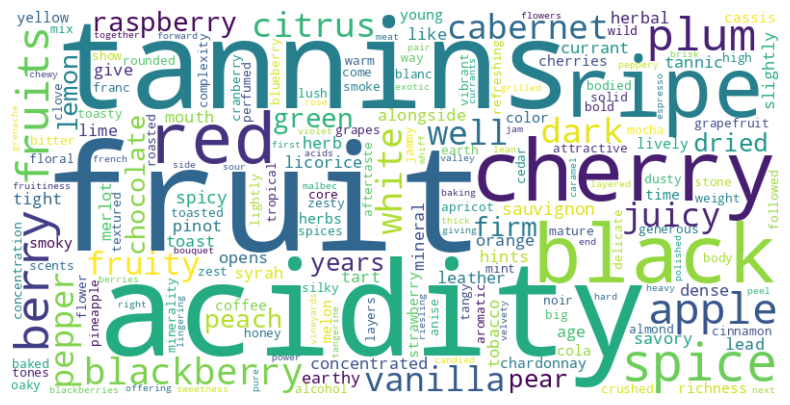

In [ ]:
# Contagem de palavras nos tokens p√≥s-filtragem
word_counts = Counter(itertools.chain.from_iterable(df_wine['tokens']))

# Gere a nuvem de palavras a partir do objeto Counter
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Exiba a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

###Correla√ß√£o entre faixa de pre√ßo e sentimento
Cria√ß√£o da rela√ß√£o entre sentimento e pre√ßo, utilizando as labels de faixa_preco: baixo, m√©dio, alto e premium.

In [ ]:
# Agrupe por 'faixa_preco' para obter uma tabela resumida
tabela_resumida = df_wine.groupby('faixa_preco', observed=False).agg(
    Quantidade_Vinhos=('title', 'count'),
    Sentimento_Medio=('sentiment', 'mean')
).reset_index()

# Calcule a porcentagem que cada faixa representa
total_vinhos = len(df_wine)
tabela_resumida['Porcentagem'] = (tabela_resumida['Quantidade_Vinhos'] / total_vinhos) * 100

# Formate a porcentagem para duas casas decimais e o sentimento para tr√™s
tabela_resumida['Porcentagem'] = tabela_resumida['Porcentagem'].map('{:.2f}%'.format)
tabela_resumida['Sentimento_Medio'] = tabela_resumida['Sentimento_Medio'].map('{:.3f}'.format)

# Renomeie a coluna de faixa de pre√ßo para melhor visualiza√ß√£o
tabela_resumida.rename(columns={'faixa_preco': 'Faixa de Pre√ßo'}, inplace=True)

# Exiba a tabela
print(tabela_resumida)

  Faixa de Pre√ßo  Quantidade_Vinhos Sentimento_Medio Porcentagem
0          baixo              46341            0.483      35.65%
1          m√©dio              52330            0.519      40.26%
2           alto              27934            0.541      21.49%
3        premium               3366            0.621       2.59%


####Gr√°fico
Gr√°fico de barras para representar a diferen√ßa no sentimento m√©dio entre as faixas de pre√ßo de forma clara

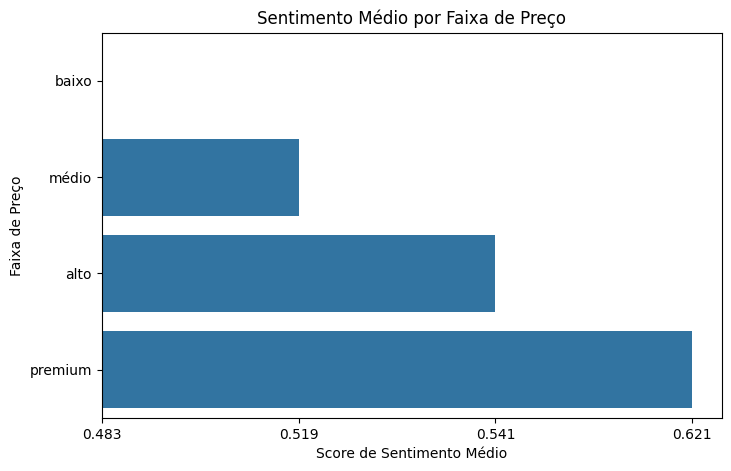

In [ ]:
# Crie um gr√°fico de barras simples, agora horizontal
plt.figure(figsize=(8, 5))
sns.barplot(data=tabela_resumida, y='Faixa de Pre√ßo', x='Sentimento_Medio', orient='h') # Swap x and y and set orient to 'h'
plt.title('Sentimento M√©dio por Faixa de Pre√ßo')
plt.xlabel('Score de Sentimento M√©dio') # Swap labels
plt.ylabel('Faixa de Pre√ßo') # Swap labels
plt.show()

####*An√°lise*

Com base na tabela resumida por faixa de pre√ßo, podemos tirar as seguintes conclus√µes:

Rela√ß√£o entre Pre√ßo e Sentimento: H√° uma clara tend√™ncia de aumento no sentimento m√©dio das avalia√ß√µes √† medida que a faixa de pre√ßo do vinho sobe. A faixa 'baixo' tem a menor pontua√ß√£o m√©dia de sentimento (0.478), enquanto a faixa 'premium' tem a maior (0.549).

Distribui√ß√£o das Avalia√ß√µes: A base de dados est√° razoavelmente distribu√≠da entre as faixas de pre√ßo, com a maioria dos vinhos (28.15%) na faixa baixo e uma boa quantidade (24.08%) na faixa premium.

Impacto no Sentimento: O salto mais significativo no sentimento m√©dio ocorre entre as faixas baixo e m√©dio (de 0.478 para 0.518). Isso sugere que a qualidade percebida e a linguagem utilizada nas descri√ß√µes melhoram consideravelmente quando o pre√ßo do vinho sai da categoria mais baixa.

##Distribui√ß√£o de Pontua√ß√£o por Variedade de vinho
Verificar a distribui√ß√£o de pontua√ß√£o das 10 variedades de vinho mais frequentes. Isso ajudar√° a visualizar se algumas variedades t√™m notas consistentemente altas ou se a dispers√£o √© grande, independentemente do pa√≠s.

Um modelo precisa saber se, por exemplo, um 'Pinot Noir' geralmente tem notas entre 87-92, enquanto um 'Chardonnay' pode ter uma faixa mais ampla. Isso ajuda a calibrar as previs√µes.

####Gr√°fico
Analisando os dados dos 10 tipos de vinhos mais frequentes na base de dados.
O histograma abaixo apresenta o n√≠vel de dispers√£o de pontua√ß√£o de cada variedade.



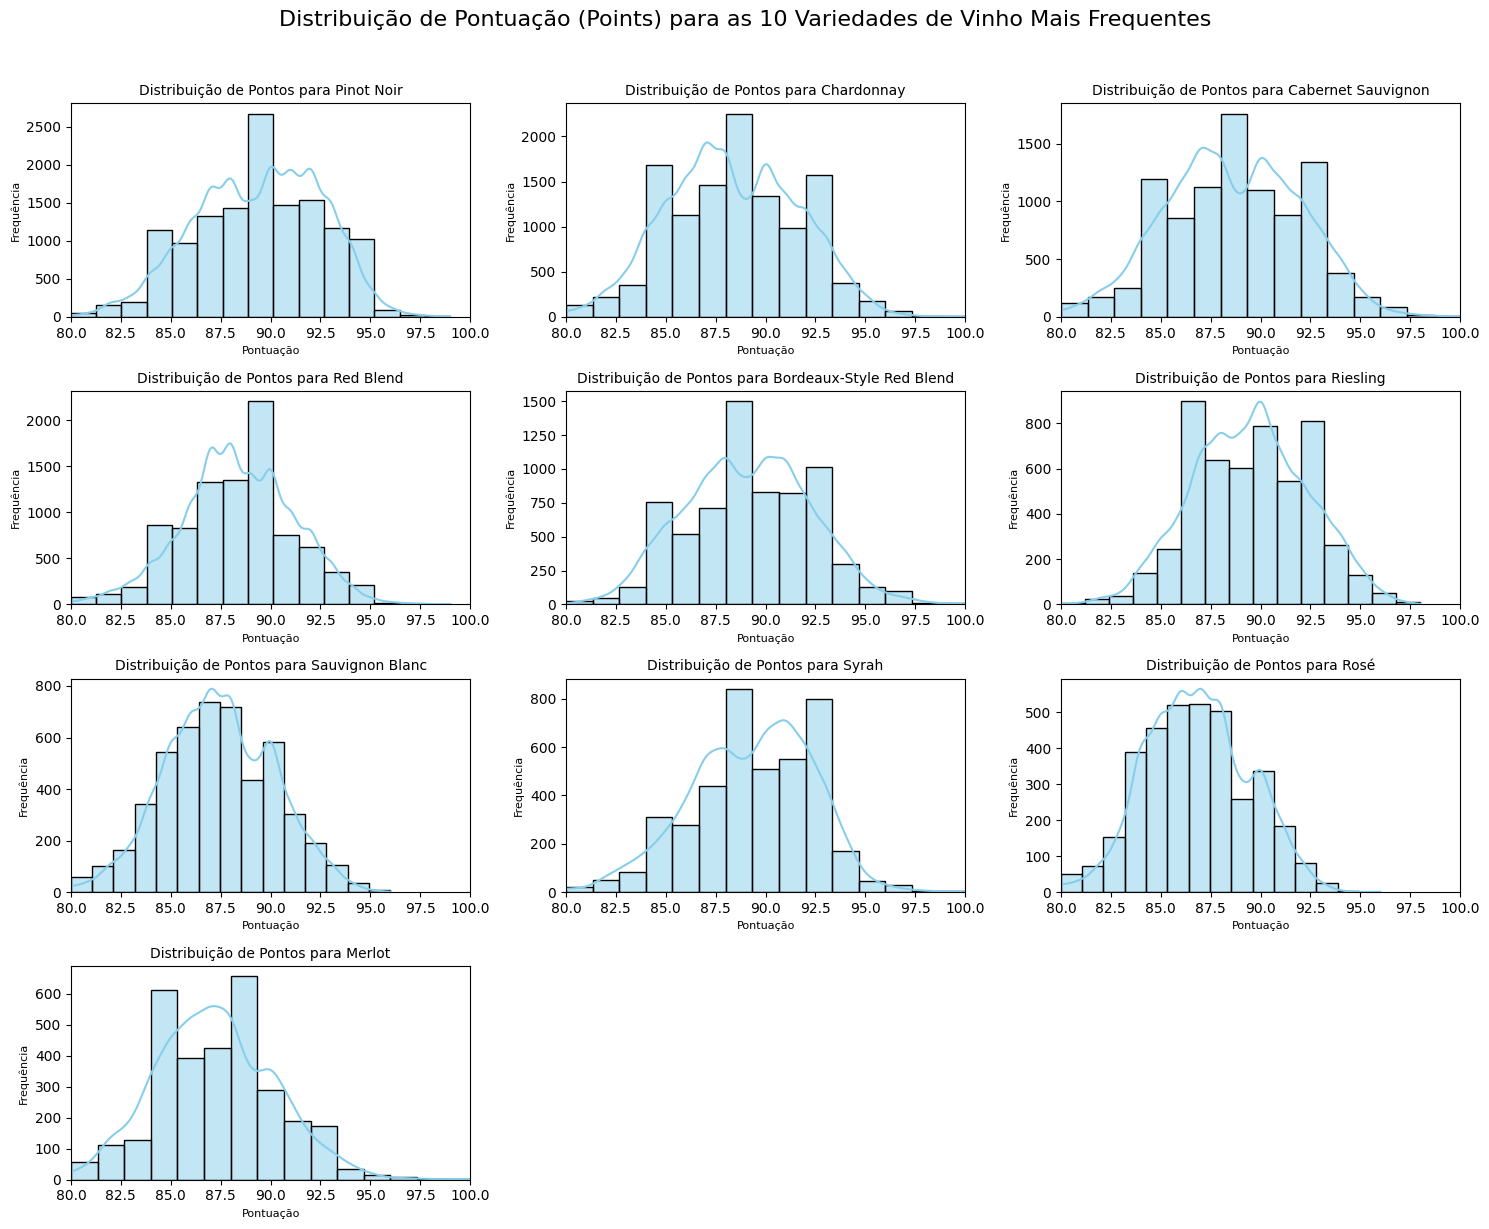

In [ ]:
# Encontre as 10 variedades mais frequentes
top_varieties = df_wine['variety'].value_counts().head(10).index.tolist()

# Crie um histograma para cada variedade
plt.figure(figsize=(15, 12))
for i, variety in enumerate(top_varieties):
    plt.subplot(4, 3, i + 1)
    sns.histplot(data=df_wine[df_wine['variety'] == variety], x='points', bins=15, kde=True, color='skyblue')
    plt.title(f'Distribui√ß√£o de Pontos para {variety.title()}', fontsize=10)
    plt.xlabel('Pontua√ß√£o', fontsize=8)
    plt.ylabel('Frequ√™ncia', fontsize=8)
    plt.xlim(80, 100)
    plt.tight_layout()

plt.suptitle('Distribui√ß√£o de Pontua√ß√£o (Points) para as 10 Variedades de Vinho Mais Frequentes', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

####*An√°lise*
Os 10 vinhos mais frequentes s√£o:
- Pinot Noir
- Chardonnay
- Cabernet Sauvignon
- Red Blended
- Bordeaux
- Riesling
- Sauvingon Blanc
- Syrah
- Ros√©
- Merlot

Para as 10 variedades de vinho mais frequentes, a distribui√ß√£o das notas √© bastante consistente, com a maioria dos vinhos recebendo pontua√ß√µes acima de 85 at√© 90 e poucos, com n√≠tida queda a partir dos 95 pontos. Isso indica que as notas dos vinhos mais comuns tendem a ser consistentemente boas ou muito boas.

O histograma mostra pouqu√≠ssimos vinhos com notas abaixo de 80. Isso pode indicar um vi√©s no conjunto de dados, onde a maioria dos vinhos avaliados j√° s√£o de uma qualidade aceit√°vel, ou que vinhos de qualidade muito baixa simplesmente n√£o s√£o inclu√≠dos nas avalia√ß√µes.

Para um modelo de Machine Learning, essa an√°lise √© valiosa. Ela confirma a import√¢ncia da vari√°vel variety como um preditor-chave e sugere que o modelo pode ter um desempenho mais f√°cil e preciso para variedades com uma distribui√ß√£o de notas mais consistente. Tamb√©m levanta a quest√£o do vi√©s do dataset, que deve ser considerado em etapas futuras.

##Distribui√ß√£o de pre√ßo por tipo e seus top 5 pa√≠ses de produ√ß√£o
Para as 10 variedades mais populares, analisaremos a distribui√ß√£o de pre√ßos pelos 5 pa√≠ses que mais produzem cada variedade. Ajudar√° a identificar se a rela√ß√£o entre pre√ßo muda dependendo de onde o vinho √© produzido.

Puxando os 10 vinhos mais frequentes e os 5 pa√≠ses que mais os produzem.

In [ ]:
# Encontre as 10 variedades mais frequentes
top_varieties = df_wine['variety'].value_counts().head(10).index.tolist()

# Prepare um DataFrame para o plot
plot_data = []

# Para cada variedade, encontre os 5 pa√≠ses que mais a produzem e colete os dados
for variety in top_varieties:
    df_variety = df_wine[df_wine['variety'] == variety]
    top_countries_for_variety = df_variety['country'].value_counts().head(5).index.tolist()

    df_filtered = df_variety[df_variety['country'].isin(top_countries_for_variety)].copy()
    df_filtered['top_variety'] = variety.title()
    plot_data.append(df_filtered)

df_plot = pd.concat(plot_data)

####Gr√°fico

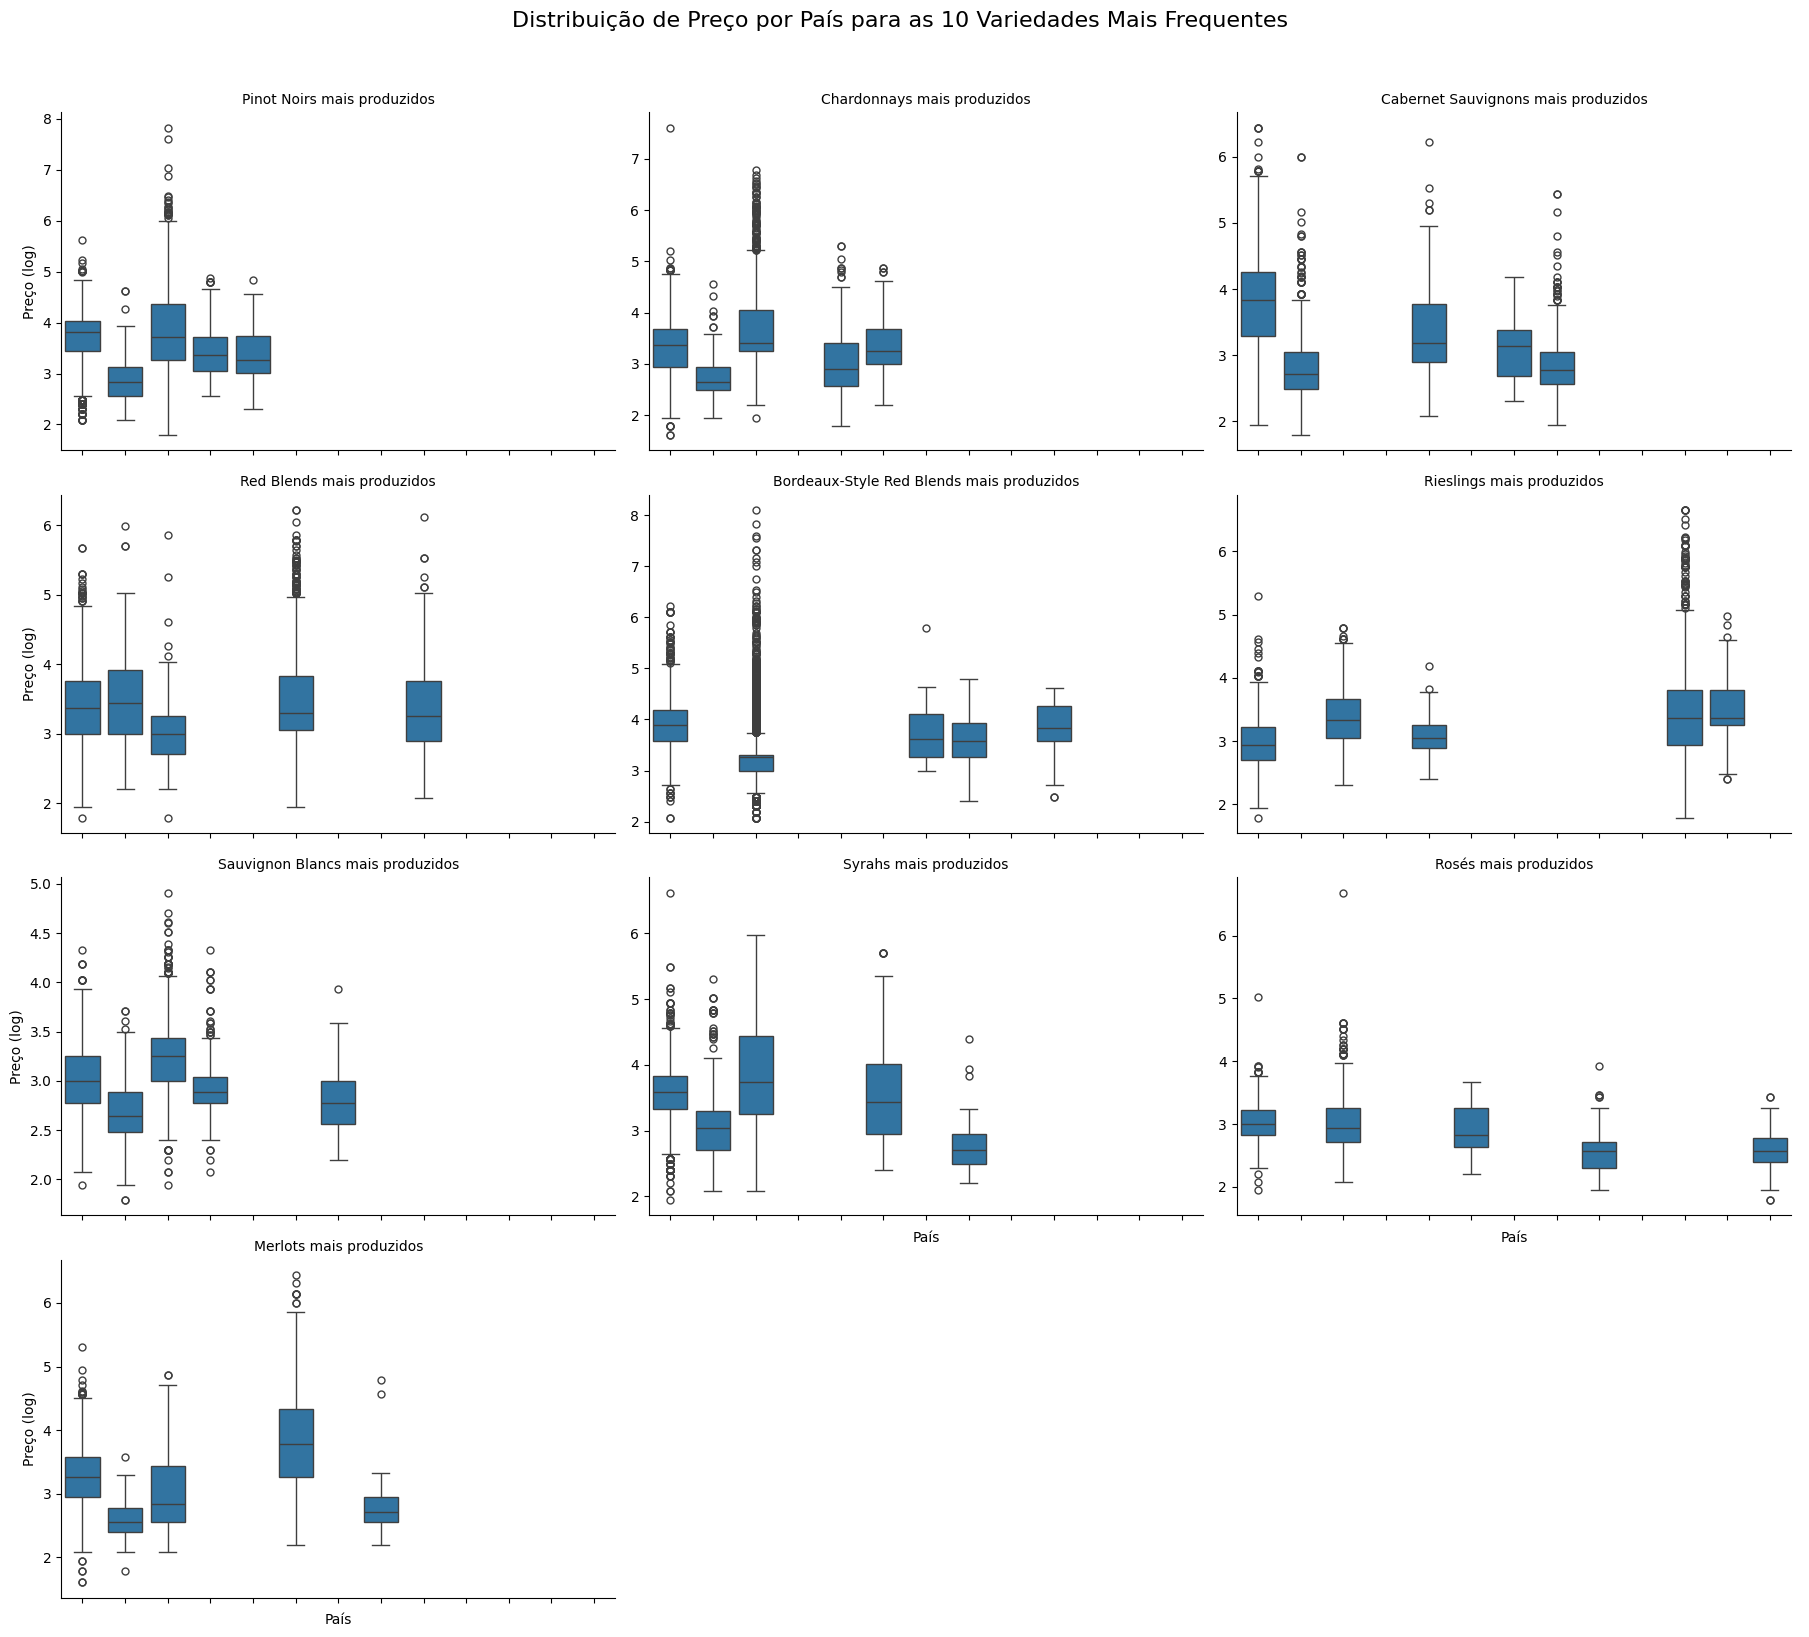

In [ ]:
# Crie o boxplot agrupado para o pre√ßo
g_price = sns.catplot(
    data=df_plot,
    x='country',
    y='log_preco',
    col='top_variety',
    kind='box',
    col_wrap=3,
    height=4,
    aspect=1.5,
    sharey=False
)

# Adicione t√≠tulos e ajuste o layout
g_price.set_axis_labels('Pa√≠s', 'Pre√ßo (log)')
g_price.set_titles('{col_name}s mais produzidos')
plt.suptitle('Distribui√ß√£o de Pre√ßo por Pa√≠s para as 10 Variedades Mais Frequentes', fontsize=16, y=1.02)

# Corre√ß√£o da rota√ß√£o e alinhamento dos r√≥tulos e adicionar o r√≥tulo do eixo x para cada subplot
for ax in g_price.axes.flat:
    ax.set_xticks(ax.get_xticks())
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')

plt.tight_layout()
plt.show()

####*An√°lise*
O gr√°fico confirma que, para uma mesma variedade de vinho, a distribui√ß√£o de pre√ßos varia significativamente dependendo do pa√≠s produtor. Isso valida a hip√≥tese de que a rela√ß√£o entre pre√ßo e tipo de vinho √© insepar√°vel da sua origem.

Essa an√°lise visual √© crucial para o modelo de Machine Learning. Ela demonstra que a vari√°vel country (pa√≠s) √© um fator de intera√ß√£o fundamental. Um modelo de recomenda√ß√£o que considere apenas a variedade pode errar nas previs√µes de pre√ßo.

## Gera√ß√£o dos Embedding usando [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)
O modelo mapeia Frases e Paragrafos em um plano vetorial de 384 dimens√µes, e pode ser usado para clusterizar sentido de palavras

In [ ]:
# ---------------------------------------------------
# 1. Agrupando o DataFrame para ser usado para gerar os Embeddings
# ---------------------------------------------------
df_grouped = df_wine.groupby('title').agg(
    points=('points', 'mean'),
    price=('price', 'mean'),
    sentiment=('sentiment', 'mean'),
    description=('description', lambda x: ' '.join(x)),
    tokens=('tokens', lambda x: list(itertools.chain.from_iterable(x)))
).reset_index()

print("DataFrame agrupado por t√≠tulo:")
display(df_grouped.head())

# ---------------------------------------------------
# 2. Inicializar modelo de embeddings sem√¢nticos
# ---------------------------------------------------
print("üîπ Carregando modelo de embeddings sem√¢nticos...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# ---------------------------------------------------
# 3. Criar embeddings das descri√ß√µes dos vinhos
# ---------------------------------------------------
print("üîπ Gerando embeddings das descri√ß√µes...")
df_grouped['embedding'] = list(model.encode(
    df_grouped['description'].fillna('').tolist(),
    normalize_embeddings=True,
    show_progress_bar=True
))

df_wine.to_parquet('wine_embedded_grouped.parquet', index=False)

üîπ Carregando modelo de embeddings sem√¢nticos...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# ---------------------------------------------------
# 4. Fun√ß√£o para recomendar vinhos
# ---------------------------------------------------
def recomendar_vinho(df_wine, texto, top_n=5):
    """
    Recebe um texto de entrada e retorna os vinhos mais similares semanticamente.
    """

    # Gerar embedding do texto de entrada
    query_emb = sentence_model.encode([texto], normalize_embeddings=True)

    # Calcular similaridade com todas as descri√ß√µes
    all_embeddings = np.vstack(df_wine['embedding'])
    sim = cosine_similarity(query_emb, all_embeddings).flatten()

    # Pegar os √≠ndices dos mais similares
    top_idx = sim.argsort()[-top_n:][::-1]

    # Retornar DataFrame com similaridade
    resultados = df_wine.iloc[top_idx][['description', 'tokens', 'title', 'variety', 'province']].copy()
    resultados['similaridade'] = sim[top_idx]

    return resultados.reset_index(drop=True)


# ---------------------------------------------------
# 5. Exemplo de uso
# ---------------------------------------------------
entrada = "spicy vinegar"
recomendacoes = recomendar_vinho(df_wine, entrada, top_n=1)

print("üç∑ Recomenda√ß√µes mais pr√≥ximas da sua descri√ß√£o:\n")
print(recomendacoes[['title','similaridade', 'description']])

ValueError: could not convert string to float: np.str_('[')